In [8]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile
import sys

In [2]:

def create_graph(pb_file):
        """"Creates a graph from saved GraphDef file and returns a Graph object.
        Returns:
        Graph holding the trained Inception network.
        """
        model_filename = pb_file
        with gfile.FastGFile(model_filename, 'rb') as f:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(f.read())
                tf.import_graph_def(graph_def, name='')

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
        w, h = im.shape[:2]
        ret = np.empty((w, h, 3), dtype=np.uint8)
        ret[:, :, 0] = im
        ret[:, :, 1] = im
        ret[:, :, 2] = im
        return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
        n, w, h = im.shape[:3]
        ret = np.empty((n, w, h, 3), dtype=np.uint8)
        ret[:, :, :, 0] = im[:,:,:,0]
        ret[:, :, :, 1] = im[:,:,:,0]
        ret[:, :, :, 2] = im[:,:,:,0]
        return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
        e = np.exp(x - np.max(x))  # prevent overflow
        if e.ndim == 1:
                return e / np.sum(e, axis=0)
        else:
                return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [4]:
chk_start = 1
step = 1
#logfile = open("/data/1M_tags/{}_log.txt".format(chk_start), 'w')


# ### TEST ###
# p = mp.Pool(8)
# print zip([1,2,3],[4,5,6])
# print p.map(f_star, itertools.izip([1,2,3], itertools.repeat(4)))
# exit()

#graph = create_graph"/data/retrain_manualtags/output_graph_best.pb")
create_graph("/data/classify_image_graph_def.pb")
with tf.device('/cpu:0'):
        sess = tf.Session()

params = pickle.load(open("/data/10k_aug_outputs/output_params_lr1e-3_adam9800.pkl", 'r'))
fw = params["final_weights"]
print "fw: ", fw
fb = params["final_biases"]
print "fb: ", fb

labels = []
with open("/data/10k_aug_outputs/output_labels9800.txt", 'r') as ifile:
        for line in ifile:
                labels.append(line.rstrip())

# read in hdf5 file
print "Reading in hdf5"
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_w11ktags.pkl", 'r'))

softmax_tensor = sess.graph.get_tensor_by_name('pool_3:0')
for chk in range(chk_start, chk_start + step):
        chunk = "Chunk" + str(chk)
        if chunk not in image_hdf5: continue
        print chunk
        #logfile.write("{}\n".format(chunk))

        idx_to_scores = {}  # scores (12 elements) for each image
        for i in range(5):
            #if i % 100 == 0:
            print "\t{}".format(i)
                #logfile.write("\t{}\n".format(i))

            try:
                a = [to_rgb(image_hdf5[chunk][i][:,:,0])] # (1,224,224,3)
                preds = sess.run(softmax_tensor, {'ExpandDims:0': a})[:,0,0,:]  # (1,2048)
                idx_to_scores[i] = np.array(softmax((np.dot(preds, fw) + fb)[0]))  # (,12)
                #idx_to_scores[i] = preds
                # f = time.time()
            except:
                continue
                
            print "a:", a
            print "preds:", preds
            print "idx_to_scores[i]:", idx_to_scores[i]

        pickle.dump(idx_to_scores, open("/data/test/{}.pkl".format(chunk), 'w'))

fw:  [[ 0.18030347 -0.2323004   0.08016818 ...,  0.17294963  0.04513717
   0.02406488]
 [ 0.01733756  0.14910389 -0.20717461 ...,  0.00111099  0.03036403
  -0.2300929 ]
 [-0.1615766  -0.00713139  0.24471194 ..., -0.07365146  0.01860937
   0.14786136]
 ..., 
 [-0.00793352 -0.10645234  0.07914906 ..., -0.02450521  0.01996998
   0.03779877]
 [ 0.28923404  0.00838811  0.17635524 ..., -0.39399898  0.13298385
   0.12649344]
 [ 0.09863782 -0.17418385  0.12918821 ..., -0.07186733  0.04572259
  -0.15016074]]
fb:  [ 0.08721535 -0.0053065  -0.02215495 -0.10461356 -0.09872913 -0.00796383
 -0.10616022  0.03630459  0.11796831 -0.01285281 -0.03057676  0.10053284]
Reading in hdf5
Chunk1
	0
a: [array([[[234, 234, 234],
        [234, 234, 234],
        [233, 233, 233],
        ..., 
        [240, 240, 240],
        [241, 241, 241],
        [241, 241, 241]],

       [[236, 236, 236],
        [237, 237, 237],
        [234, 234, 234],
        ..., 
        [240, 240, 240],
        [241, 241, 241],
        

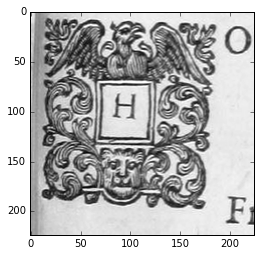

In [17]:
plt.imshow(image_hdf5["Chunk1"][0][:,:,0], cmap=mpl.cm.gray)
